In [132]:
import pandas as pd
import numpy as np
import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
data = pd.read_csv('ALL_data.csv', index_col='PID')
sector = pd.read_csv('sectors_walmart.csv', index_col='PID')
data = data.merge(sector[['Sector','DfromWalmart']], on='PID')
data.shape

(2579, 83)

In [9]:
# Define y as "SalePrice"
y = data.SalePrice.copy()

## 🧪 <span style='background:yellow'> Try Multiple Linear Regression </span>
* Split data into Train and Test sets
* Use Lasso to select best features

In [4]:
size_related = data.filter(regex='SF$|Area$|(Porch)')
size_related.isnull().sum(axis=0)

GrLivArea         0
LotArea           0
MasVnrArea       14
BsmtUnfSF         1
TotalBsmtSF       1
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GarageArea        1
WoodDeckSF        0
OpenPorchSF       0
EnclosedPorch     0
3SsnPorch         0
ScreenPorch       0
PoolArea          0
dtype: int64

In [5]:
size_related = size_related.fillna(0.0)  # We fill the very minor missing values by 0.0

### Create new Feature called <span style="color:brown">PorchArea</span> (Sum of all Porch & Deck)
* WoodDeckSF + OpenPorchSF + EnclosedPorch + 3SsnPorch + ScreenPorch

In [6]:
size_related['PorchArea'] = size_related[['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch']].sum(axis=1)
size_related.drop(['WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch'],axis=1,inplace=True)

#### Remove potential collinearity features
* **only Keep**: LotArea, 1stFlrSF, 2ndFlrSF, GarageArea, PorchArea

In [7]:
X = size_related[['LotArea', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'PorchArea']]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)

In [11]:
lasso_lm = Lasso()
lasso_lm.set_params(normalize=False)

Lasso()

In [12]:
#try different alphas
alphas = np.linspace(0.001,50,200)
coefs_lasso = []
R2_train = []
R2_test = []

for a in alphas:
    lasso_lm.set_params(alpha=a)
    lasso_lm.fit(X_train, np.log10(y_train))
    coefs_lasso.append(lasso_lm.coef_)
    R2_train.append(lasso_lm.score(X_train, np.log10(y_train)))
    R2_test.append(lasso_lm.score(X_test, np.log10(y_test)))

In [13]:
coefs_lasso = pd.DataFrame(coefs_lasso, index = alphas, columns = X_train.columns)
R2_lasso = pd.DataFrame({'train': R2_train,'test':R2_test}, index = alphas)
coefs_lasso.head(2)

,LotArea,1stFlrSF,2ndFlrSF,GarageArea,PorchArea
0.001000,2.404249e-07,0.00023,0.000139,0.000279,0.000104
0.252251,2.880177e-07,0.00023,0.000138,0.000275,0.000096


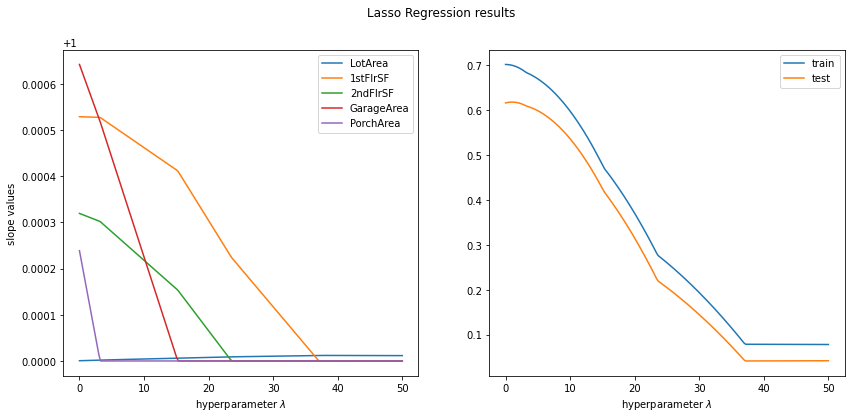

In [144]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Lasso Regression results')

for feat in coefs_lasso.columns:
    ax1.plot(coefs_lasso.index, 10**coefs_lasso[feat], label=feat) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'slope values')
ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)

#### 1stFlr and 2ndFlr are best, Maybe Garage

In [17]:
lm = LinearRegression()
lm.fit(X_train,np.log10(y_train))
lm.score(X_test,np.log10(y_test))

0.6165579769266639

In [19]:
vif = pd.DataFrame()
vif['var'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,var,VIF
0,LotArea,2.808927
1,1stFlrSF,9.666886
2,2ndFlrSF,1.753926
3,GarageArea,8.697197
4,PorchArea,2.763854


#### High VIFs (1stFlrSF and GarageArea), 
* try removing Garage

In [20]:
X = size_related[['LotArea', '1stFlrSF', '2ndFlrSF', 'PorchArea']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)
lm = LinearRegression()
lm.fit(X_train,np.log10(y_train))
lm.score(X_test,np.log10(y_test))

0.5781747664657413

In [21]:
vif = pd.DataFrame()
vif['var'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif

,var,VIF
0,LotArea,2.808449
1,1stFlrSF,3.990350
2,2ndFlrSF,1.514106
3,PorchArea,2.752236


## 🧪Try 
1. Bsmt, Garage, Pool, DeckORPorch into **<span style="color:red">BINARY</span>** features (Y or N)
2. Remove **LotArea**

In [22]:
size_related['Bsmt_YN'] = size_related.TotalBsmtSF != 0
size_related['Garage_YN'] = size_related.GarageArea != 0
size_related['Pool_YN'] = size_related.PoolArea != 0
size_related['DeckPorch_YN'] = size_related.PorchArea != 0

#### Multiple Regression with the 3 Continuous features from before plus the 4 new Binary features

In [125]:
X = size_related[['1stFlrSF', '2ndFlrSF','Bsmt_YN','Garage_YN','Pool_YN','DeckPorch_YN']].copy()

In [40]:
#Check
X[['Bsmt_YN','Garage_YN','Pool_YN','DeckPorch_YN']].sum(axis=0)

Bsmt_YN         2510
Garage_YN       2451
Pool_YN            9
DeckPorch_YN    2147
dtype: int64

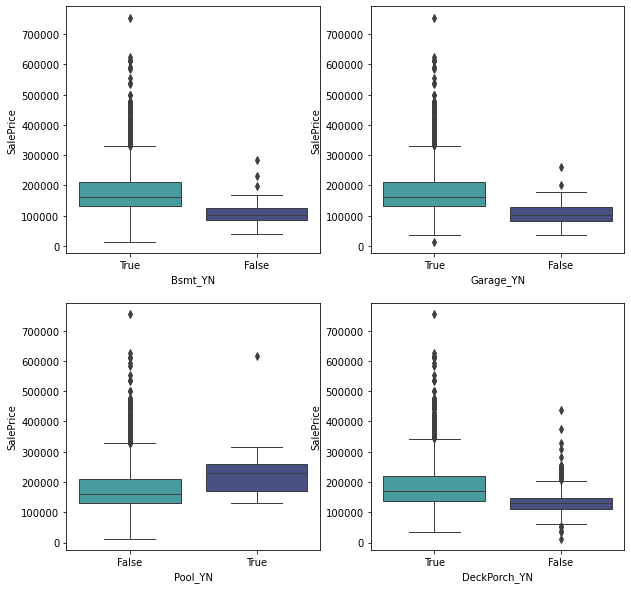

In [42]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

for idx, COL in enumerate(X.drop(['1stFlrSF', '2ndFlrSF'], axis=1).columns):
    sns.boxplot(ax=ax[idx//2,idx%2],
            x=X[COL], y=y, 
            order = X[COL].value_counts().index,
            palette="mako_r", linewidth=1)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)
lm = LinearRegression()
lm.fit(X_train,np.log10(y_train))
lm.score(X_test,np.log10(y_test))

0.6233449100379519

#### <span style="color:green">Interpret Coefficients</span> 💹

In [44]:
print(f'Intercept: {round(10**lm.intercept_,3)}')
pd.DataFrame(np.round(((10**lm.coef_-1)*100),3),index=X.columns)

Intercept: 31620.086


,0
1stFlrSF,0.072
2ndFlrSF,0.040
Bsmt_YN,43.363
Garage_YN,30.124
Pool_YN,-11.513
DeckPorch_YN,12.179


## 🧪Try 
* 2nd floor Area (2ndFlrSF): **bin** and dummify

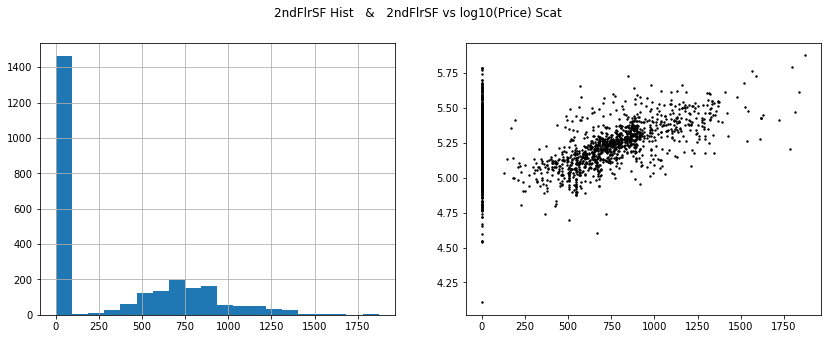

In [83]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
fig.suptitle('2ndFlrSF Hist   &   2ndFlrSF vs log10(Price) Scat')

X['2ndFlrSF'].hist(ax=ax1, bins=20)
ax2.scatter(x=X['2ndFlrSF'],y=np.log10(y),s=2,c='k')

In [126]:
X['2F_Class'] = pd.cut(x=X['2ndFlrSF'] , bins=[-1,1,650,850,5000], labels=['2F_0','2F_650under','2F_850under','2F_850plus'])

In [127]:
X['2F_Class'].value_counts()

2F_0           1464
2F_850plus      388
2F_850under     368
2F_650under     359
Name: 2F_Class, dtype: int64

In [128]:
X = pd.concat([X, pd.get_dummies(X['2F_Class'], drop_first=True)],axis=1)
X.drop(['2ndFlrSF','2F_Class'],axis=1, inplace=True)

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)
lm = LinearRegression()
lm.fit(X_train,np.log10(y_train))
lm.score(X_test,np.log10(y_test))

0.6227983916083779

#### <span style="color:green">Interpret Coefficients</span> 💹

In [131]:
print(f'Intercept: {round(10**lm.intercept_,3)}')
pd.DataFrame(np.round(((10**lm.coef_-1)*100),3),index=X.columns)

Intercept: 32493.378


,0
1stFlrSF,0.070
Bsmt_YN,43.907
Garage_YN,30.415
Pool_YN,-10.325
DeckPorch_YN,11.552
2F_650under,10.267
2F_850under,35.829
2F_850plus,55.340


#### Tho no improvement from leaving 2ndFlrSF unbinned

## 🧪 <span style='background:yellow'> Bring in other features </span>
* YearBuilt / OverallQual / DfromWalmart

In [33]:
X = X.merge(data[['YearBuilt','OverallQual','DfromWalmart']], on='PID')

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=44)
lm = LinearRegression()

In [36]:
# Simple on YEARBUILT
lm.fit(X_train[['YearBuilt']],np.log10(y_train))
lm.score(X_test[['YearBuilt']],np.log10(y_test))

0.37724749993317375

In [37]:
# Simple on OverallQual
lm.fit(X_train[['OverallQual']],np.log10(y_train))
lm.score(X_test[['OverallQual']],np.log10(y_test))

0.6569135330651092

In [38]:
# Simple on DfromWalmart
lm.fit(X_train[['DfromWalmart']],np.log10(y_train))
lm.score(X_test[['DfromWalmart']],np.log10(y_test))

0.21923436192912382

#### 🧵 Ridge

In [133]:
ridge = Ridge()
ridge.set_params(normalize=True)

Ridge(normalize=True)

In [145]:
alphas = np.arange(0,20)
coefs_ridge  = []
R2_train = []
R2_test = []
for alpha in alphas:
    ridge.set_params(alpha=alpha)
    ridge.fit(X_train, np.log10(y_train))
    coefs_ridge.append(ridge.coef_)
    R2_train.append(ridge.score(X_train, np.log10(y_train)))
    R2_test.append(ridge.score(X_test, np.log10(y_test)))

In [146]:
coefs_ridge = pd.DataFrame(coefs_ridge, index=alphas, columns=X_train.columns)
R2_ridge = pd.DataFrame({'R2_train':R2_train,'R2_test':R2_test})
coefs_ridge.head(2)

,1stFlrSF,Bsmt_YN,Garage_YN,Pool_YN,DeckPorch_YN,2F_650under,2F_850under,2F_850plus
0,0.000305,0.158083,0.115329,-0.047329,0.047479,0.042445,0.132991,0.191283
1,0.000131,0.089422,0.087871,0.032612,0.046990,-0.028379,0.028751,0.082112


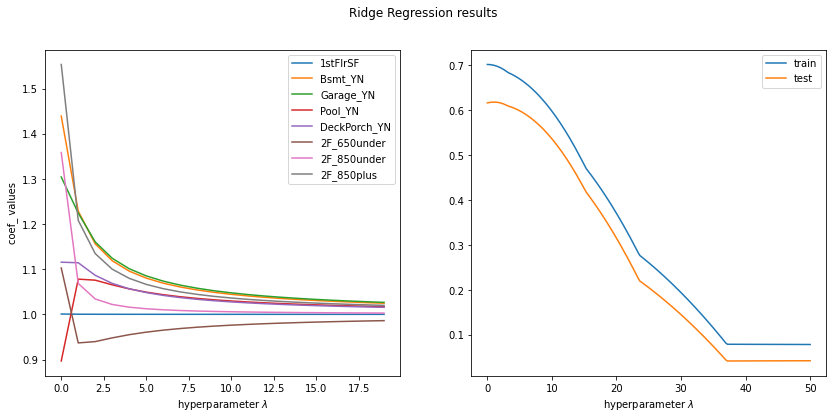

In [147]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
fig.suptitle('Ridge Regression results')

for feat in coefs_ridge.columns:
    ax1.plot(coefs_ridge.index, 10**coefs_ridge[feat], label=feat) 
ax1.set_xlabel(r'hyperparameter $\lambda$')
ax1.set_ylabel(r'coef_ values')
ax1.legend(loc=1)
for each in R2_lasso.columns:
    ax2.plot(R2_lasso.index, R2_lasso[each], label=each)
ax2.set_xlabel(r'hyperparameter $\lambda$')
ax2.legend(loc=1)